## Solving for correlations and optimal coefficients for the top 100m DIC field
(assuming perfect global coverage of T and S fields, and ignoring the propagation of information any far-field observations)

First, load in all of our python libraries, including those that I've created

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/Volumes/KT-TOSHIBA/ENOI/CODE')
import regression_fcts as rf
import cartopy.crs as ccrs
import enoi_functions as enoi

In [5]:
from dask.distributed import Client
client = Client('tcp://127.0.0.1:8786')

I also have a few functions here for common metrics, i.e., RMSE between one time series and a reconstruction, and a way to detrend the 60-year time series within the super-ensemble we use to calculate our coefficients and correlation/covariance fields

In [42]:
newcmp = enoi.n_cmap()

In [38]:
def RMSE(var1, var2, ax):
    rmse = np.sqrt(np.nanmean((var1-var2)**2,axis=ax))
    return rmse

def detrend_ens(input_ts, idx_t, tlength):
    tot_tlength = np.size(input_ts, idx_t)
    output_ts = np.ones(np.shape(input_ts))*np.nan
    if idx_t == 0:
        for i in np.arange(int(tot_tlength/tlength)):
            sample = input_ts[i*tlength:(i+1)*tlength, :,:]
            output_ts[i*tlength:(i+1)*tlength, :,:] = scipy.signal.detrend(sample, idx_t)
    return output_ts

In [3]:
mdata = '/Volumes/KT-TOSHIBA/ENOI/sorted_model_data/'

dissic_SORTED = np.load(f'{mdata}dic_100.npy')
thetao_SORTED = np.load(f'{mdata}thetao_100.npy')
so_SORTED = np.load(f'{mdata}so_100.npy')

dissic_drift = np.load(f"drift_ts_dissic0100.npy")
thetao_drift = np.load(f"drift_ts_thetao0100.npy")
so_drift = np.load(f"drift_ts_so0100.npy")

argo_coverage= xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CODE/argo_mask.nc')
argo_mask = argo_coverage.argo_annualcoverage

years_used = -60
limit_z = 100
m0 = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/forcings/mol1.nc', decode_times=False)
pco2 = m0.mole_fraction_of_carbon_dioxide_in_air[years_used:,0]
pco2_extended = np.tile(pco2.data - np.nanmean(pco2.data), 
                        int(np.shape(so_SORTED)[0]/np.abs(years_used)))

lon = np.arange(0.5,360.5)
lat = np.arange(-89.5,90.5)

mdict = {'lat':'lat', 'lon':'lon', 'lev':'lev', 'lev_bnds':'lev_bnds'}

ens_dic =  xr.DataArray(data=dissic_SORTED - dissic_drift)
ens_theta =  xr.DataArray(data=thetao_SORTED - thetao_drift)
ens_sal = xr.DataArray(data=so_SORTED - so_drift)

ens_mask = np.load(f'{mdata}mask_{limit_z}.npy')
_, l_100 = enoi.create_mask(dissic_SORTED, f'{mdata}mask_100.npy')

/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data


In [6]:
dic_resid = ens_dic - ens_dic.mean(axis=0)
theta_resid = ens_theta - ens_theta.mean(axis=0)
so_resid = ens_sal - ens_sal.mean(axis=0)

coeff_ensCO2 = np.zeros([180,360])
coeff_ensT = np.zeros([180,360])
coeff_ensS = np.zeros([180,360])
for i in np.arange(0,180):
        for j in np.arange(0,360):
            if theta_resid[0,i,j] != 0 :
                input_vars = np.stack((pco2_extended, theta_resid[:,i,j],so_resid[:,i,j]), axis=-1)
                dummy = np.linalg.lstsq(input_vars, dic_resid[:,i,j], rcond=-1)
                
                coeff_ensCO2[i,j] = dummy[0][0]
                coeff_ensT[i,j] = dummy[0][1]
                coeff_ensS[i,j] = dummy[0][2]

cCO2 = np.ma.masked_where(l_100,enoi.sew_seams(coeff_ensCO2, ens_mask))
cT = np.ma.masked_where(l_100,enoi.sew_seams(coeff_ensT, ens_mask))
cS = np.ma.masked_where(l_100,enoi.sew_seams(coeff_ensS, ens_mask))

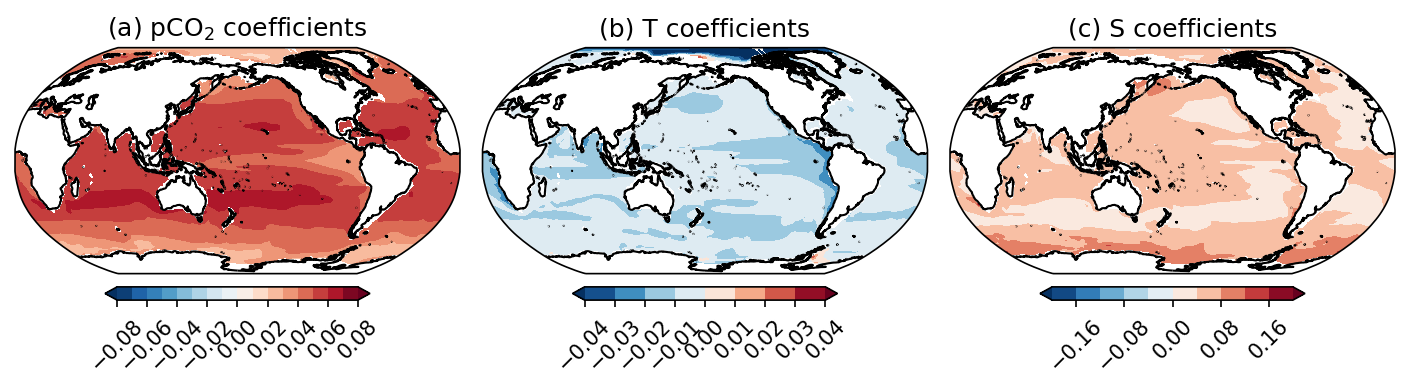

In [32]:
matplotlib.rcParams.update({'font.size': 10})
####
fig = plt.figure(figsize=(9.5, 3), dpi=150)
ax1 = plt.subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title('(a) pCO$_2$ coefficients')
ax1.coastlines('50m')
im1 = ax1.contourf(lon, lat, cCO2, np.arange(-.08,.09,.01),extend='both', transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))
cb1 = plt.colorbar(im1,ax=ax1, fraction=0.04, pad=0.04, orientation="horizontal")
cb1.ax.tick_params(rotation=45)

ax2 = plt.subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title('(b) T coefficients')
ax2.coastlines('50m')
im2 = ax2.contourf(lon, lat, cT, np.arange(-.04,.05,.01),extend='both', transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))
cb2 = plt.colorbar(im2,ax=ax2, fraction=0.04, pad=0.04, orientation="horizontal")
cb2.ax.tick_params(rotation=45)

ax3 = plt.subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title('(c) S coefficients')
ax3.coastlines('50m')
im3 = ax3.contourf(lon, lat, cS, np.arange(-.2,.24,.04),extend='both', transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))
cb3 = plt.colorbar(im3,ax=ax3, fraction=0.04, pad=0.04, orientation="horizontal")
cb3.ax.tick_params(rotation=45)

plt.tight_layout()
plt.savefig('pc_manuscript_figures/coeff_dense_t100.png', format='png', dpi=150, bbox_inches='tight')

In [7]:
corr_dicp_ens = np.zeros((180,360))
corr_tp_ens = np.zeros((180,360))
corr_ps_ens = np.zeros((180,360))
corr_dict_ens = np.zeros((180,360))
corr_ts_ens = np.zeros((180,360))
corr_dics_ens = np.zeros((180,360))
R2 = np.zeros((180,360))
for ii in np.arange(0,180):
        for j in np.arange(0,360):
            if dic_resid[1000,ii,j] != 0 :
                corr_dicp_ens[ii,j] = np.corrcoef(dic_resid[:,ii,j], pco2_extended)[0,1]
                corr_tp_ens[ii,j] = np.corrcoef(theta_resid[:,ii,j], pco2_extended)[0,1]
                corr_ps_ens[ii,j] = np.corrcoef(ens_sal[:,ii,j], pco2_extended)[0,1]
                corr_dict_ens[ii,j] = np.corrcoef(dic_resid[:,ii,j], theta_resid[:,ii,j])[0,1]
                corr_ts_ens[ii,j] = np.corrcoef(ens_sal[:,ii,j], theta_resid[:,ii,j])[0,1]
                corr_dics_ens[ii,j] = np.corrcoef(ens_sal[:,ii,j], dic_resid[:,ii,j])[0,1]
        
dicp1 = np.ma.masked_where(l_100,enoi.sew_seams(corr_dicp_ens, ens_mask))
tp1 = np.ma.masked_where(l_100,enoi.sew_seams(corr_tp_ens, ens_mask))
sp1 = np.ma.masked_where(l_100,enoi.sew_seams(corr_ps_ens, ens_mask))
dict1 = np.ma.masked_where(l_100,enoi.sew_seams(corr_dict_ens, ens_mask))
ts1 = np.ma.masked_where(l_100,enoi.sew_seams(corr_ts_ens, ens_mask))
dics1 = np.ma.masked_where(l_100,enoi.sew_seams(corr_dics_ens, ens_mask))

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_53247/2908550185.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


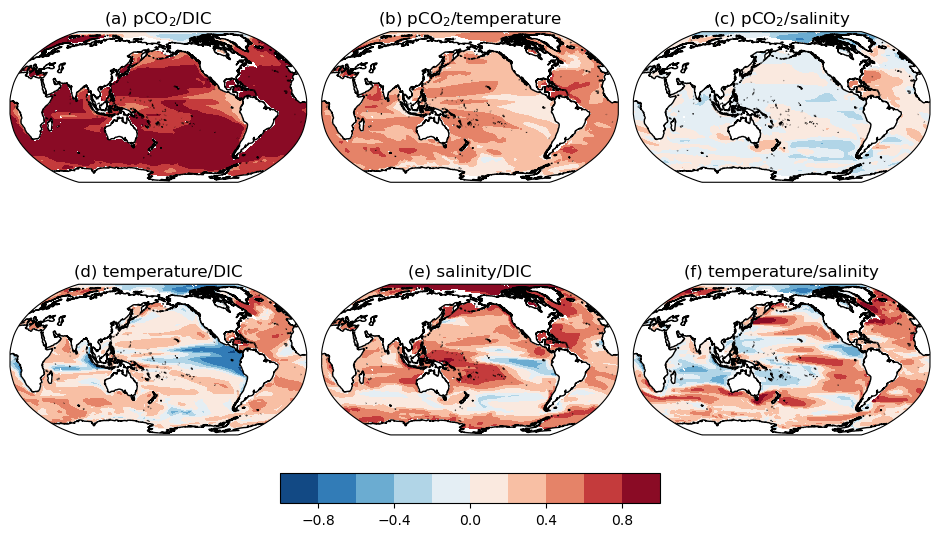

In [48]:
fig = plt.figure(figsize=(9.5, 6))
ax1 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title('(a) pCO$_2$/DIC')
ax1.coastlines('50m')
ax1.contourf(lon, lat, dicp1, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax2 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title('(b) pCO$_2$/temperature')
ax2.coastlines('50m')
ax2.contourf(lon, lat, tp1, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax3 = plt.subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title('(c) pCO$_2$/salinity')
ax3.coastlines('50m')
ax3.contourf(lon, lat, sp1, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax4 = plt.subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=180))
plt.title('(d) temperature/DIC')
ax4.coastlines('50m')
ax4.contourf(lon, lat, dict1, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax5 = plt.subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=180))
plt.title('(e) salinity/DIC')
ax5.coastlines('50m')
ax5.contourf(lon, lat, dics1, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax6 = plt.subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=180))
plt.title('(f) temperature/salinity')
ax6.coastlines('50m')
im = ax6.contourf(lon, lat, ts1, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax_cbar1 = fig.add_axes([0.3, 0.05, .4, 0.05])
fig.colorbar(im, cax=ax_cbar1, orientation="horizontal", pad=0.2)
plt.tight_layout()
plt.savefig('pc_manuscript_figures/corr_dense_t100.png', format='png', dpi=150, bbox_inches='tight')

Using model climatology as background state
Using model climatology as background state
Using model climatology as background state


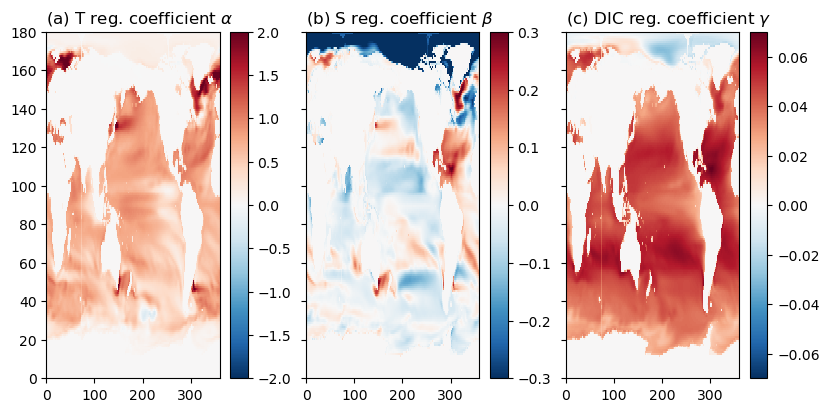

In [8]:
pco2_coef_T,_,_ = rf.multivar_reg(theta_resid,pco2_extended, 1)
pco2_coef_C,_,_ = rf.multivar_reg(dic_resid,pco2_extended, 1)
pco2_coef_S,_,_ = rf.multivar_reg(so_resid,pco2_extended, 1)

fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=((9.5,4.5)))
f0 = axs[0].pcolormesh(pco2_coef_T, vmin=-2, vmax=2, cmap="RdBu_r")
axs[0].set_title(r'(a) T reg. coefficient $\alpha$', loc='left')
plt.colorbar(f0,ax=axs[0])
    
f1 = axs[1].pcolormesh(pco2_coef_S, vmin=-.3, vmax=.3, cmap="RdBu_r")
axs[1].set_title(r'(b) S reg. coefficient $\beta$', loc='left')
plt.colorbar(f1, ax=axs[1])
    
f2 = axs[2].pcolormesh(pco2_coef_C, vmin=-.07, vmax=.07, cmap="RdBu_r")
axs[2].set_title(r'(c) DIC reg. coefficient $\gamma$', loc='left')
plt.colorbar(f2, ax=axs[2])

In [21]:
corr_dict_ens = np.zeros((180,360))
corr_ts_ens = np.zeros((180,360))
corr_dics_ens = np.zeros((180,360))
for ii in np.arange(0,180):
        for j in np.arange(0,360):
            if dic_resid[1000,ii,j] != 0 :
                corr_dict_ens[ii,j] = np.corrcoef(dic_resid[:,ii,j], theta_resid[:,ii,j])[0,1]
                corr_ts_ens[ii,j] = np.corrcoef(so_resid[:,ii,j], theta_resid[:,ii,j])[0,1]
                corr_dics_ens[ii,j] = np.corrcoef(so_resid[:,ii,j], dic_resid[:,ii,j])[0,1]
        
std_dic = np.std(dic_resid, axis=0).data
std_theta = np.std(theta_resid, axis=0).data
std_so = np.std(so_resid, axis=0).data
var_pco2 = np.std(pco2_extended)**2

cov_ts_anom = np.zeros((180,360))
cov_dics_anom = np.zeros((180,360))
cov_dict_anom = np.zeros((180,360))
for ii in np.arange(0,180):
        for j in np.arange(0,360):
            if ens_dic[1000,ii,j].data != 0 :
                t_dd = theta_resid[:,ii,j] - pco2_coef_T[ii,j] * (pco2_extended - np.nanmean(pco2))
                s_dd = so_resid[:,ii,j] - pco2_coef_S[ii,j] * (pco2_extended - np.nanmean(pco2))
                dic_dd = dic_resid[:,ii,j] - pco2_coef_C[ii,j] * (pco2_extended - np.nanmean(pco2))
                cov_ts_anom[ii,j] = np.cov(t_dd, s_dd)[0,1]
                cov_dics_anom[ii,j] = np.cov(s_dd, dic_dd)[0,1]
                cov_dict_anom[ii,j] = np.cov(dic_dd, t_dd)[0,1]         

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/2507189450.py:13: RuntimeWarning: invalid value encountered in divide
  np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_T*pco2_coef_S*var_pco2/(std_theta*std_so),ens_mask)),
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/2507189450.py:17: RuntimeWarning: invalid value encountered in divide
  np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_T*pco2_coef_C*var_pco2/(std_theta*std_dic),ens_mask)),
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/2507189450.py:21: RuntimeWarning: invalid value encountered in divide
  np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_S*pco2_coef_C*var_pco2/(std_so*std_dic),ens_mask)),
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/2507189450.py:26: RuntimeWarning: invalid value encountered in divide
  np.ma.masked_where(l_100,enoi.sew_seams(cov_ts_anom/(std_theta*std_so),ens_mask)),
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel

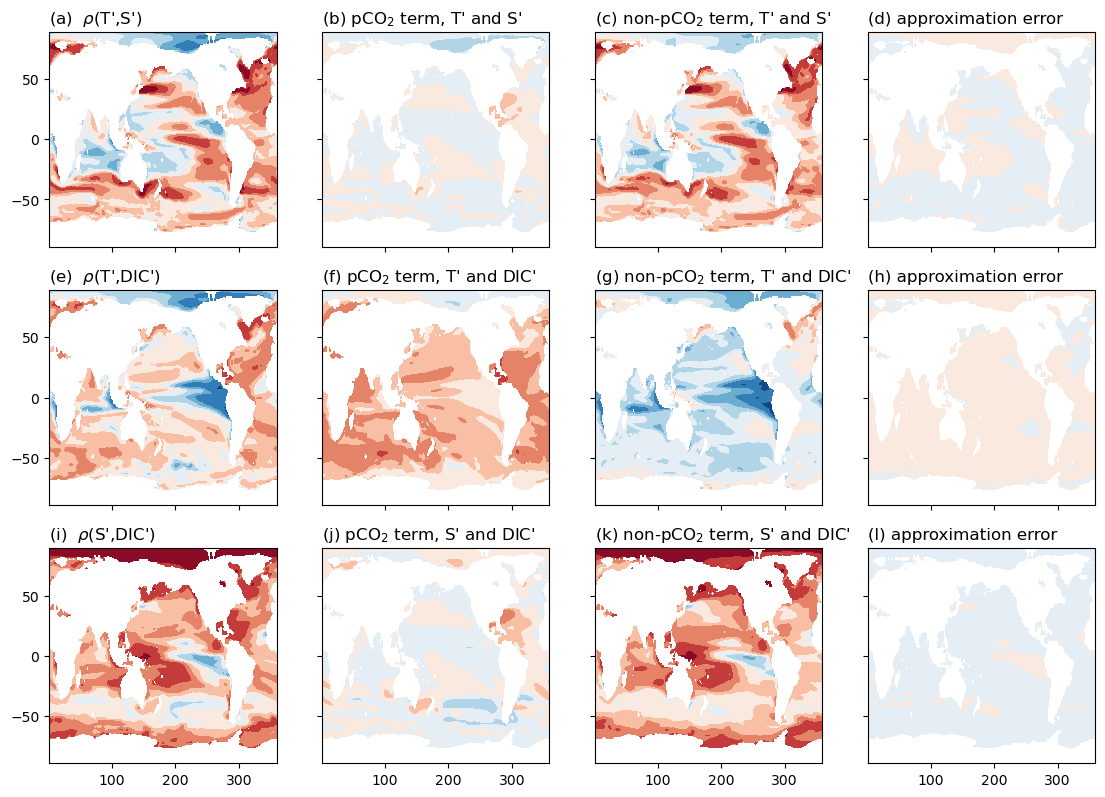

In [30]:
fig, axs = plt.subplots(3,4, sharex=True, sharey=True, figsize=((13.5,9.5)))                
f0 = axs[0,0].contourf(lon, lat, np.ma.masked_where(l_100,enoi.sew_seams(corr_ts_ens, ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[0,0].set_title(r"(a)  $\rho$(T',S')", loc="left")
f1 = axs[1,0].contourf(lon, lat, np.ma.masked_where(l_100,enoi.sew_seams(corr_dict_ens, ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[1,0].set_title(r"(e)  $\rho$(T',DIC')", loc="left")
f2 = axs[2,0].contourf(lon, lat, np.ma.masked_where(l_100,enoi.sew_seams(corr_dics_ens, ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[2,0].set_title(r"(i)  $\rho$(S',DIC')", loc="left")
    
f0a = axs[0,1].contourf(lon, lat, 
                        np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_T*pco2_coef_S*var_pco2/(std_theta*std_so),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[0,1].set_title(r"(b) pCO$_2$ term, T' and S'", loc="left")
f1a = axs[1,1].contourf(lon, lat, 
                        np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_T*pco2_coef_C*var_pco2/(std_theta*std_dic),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[1,1].set_title(r"(f) pCO$_2$ term, T' and DIC'", loc="left")
f2a = axs[2,1].contourf(lon, lat, 
                        np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_S*pco2_coef_C*var_pco2/(std_so*std_dic),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[2,1].set_title(r"(j) pCO$_2$ term, S' and DIC'", loc="left")
    
f0b = axs[0,2].contourf(lon, lat, 
                        np.ma.masked_where(l_100,enoi.sew_seams(cov_ts_anom/(std_theta*std_so),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[0,2].set_title(r"(c) non-pCO$_2$ term, T' and S'", loc="left")
f1b = axs[1,2].contourf(lon, lat, 
                        np.ma.masked_where(l_100,enoi.sew_seams(cov_dict_anom/(std_theta*std_dic),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[1,2].set_title(r"(g) non-pCO$_2$ term, T' and DIC'", loc="left")
f2b = axs[2,2].contourf(lon, lat, 
                        np.ma.masked_where(l_100,enoi.sew_seams(cov_dics_anom/(std_dic*std_so),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[2,2].set_title(r"(k) non-pCO$_2$ term, S' and DIC'", loc="left")
    
f0test = axs[0,3].contourf(lon, lat, 
                           np.ma.masked_where(l_100,enoi.sew_seams(corr_ts_ens - (pco2_coef_T*pco2_coef_S*var_pco2 + cov_ts_anom)/(std_theta*std_so),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[0,3].set_title(r"(d) approximation error", loc="left")
f1test = axs[1,3].contourf(lon, lat, 
                           np.ma.masked_where(l_100,enoi.sew_seams(corr_dict_ens - (pco2_coef_T*pco2_coef_C*var_pco2 + cov_dict_anom)/(std_theta*std_dic),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[1,3].set_title(r"(h) approximation error", loc="left")
f2test = axs[2,3].contourf(lon, lat, 
                           np.ma.masked_where(l_100,enoi.sew_seams(corr_dics_ens - (pco2_coef_C*pco2_coef_S*var_pco2 + cov_dics_anom)/(std_dic*std_so),ens_mask)),
                             np.arange(-1,1.2,.2), cmap="RdBu_r")
axs[2,3].set_title(r"(l) approximation error", loc="left")
plt.savefig('pc_manuscript_figures/app_corr_breakdown.png', format='png', dpi=150)

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/1232603436.py:1: RuntimeWarning: invalid value encountered in divide
  dict_pco2 = np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_T*pco2_coef_C*var_pco2/(std_theta*std_dic), ens_mask))
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/1232603436.py:2: RuntimeWarning: invalid value encountered in divide
  dict_anom = np.ma.masked_where(l_100,enoi.sew_seams(cov_dict_anom/(std_theta*std_dic), ens_mask))
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/1232603436.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


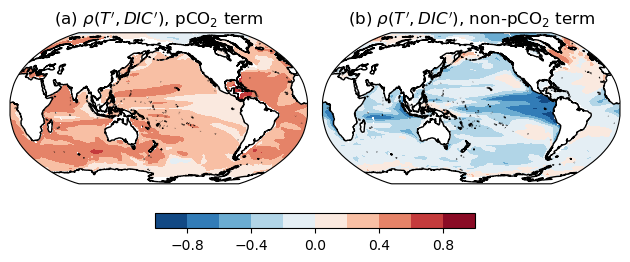

In [33]:
dict_pco2 = np.ma.masked_where(l_100,enoi.sew_seams(pco2_coef_T*pco2_coef_C*var_pco2/(std_theta*std_dic), ens_mask))
dict_anom = np.ma.masked_where(l_100,enoi.sew_seams(cov_dict_anom/(std_theta*std_dic), ens_mask))

fig = plt.figure(figsize=(6.4, 3))
ax5 = plt.subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title(r"(a) $\rho(T',DIC')$, pCO$_2$ term")
ax5.coastlines('50m')
ax5.contourf(lon, lat, dict_pco2, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

ax6 = plt.subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title(r"(b) $\rho(T',DIC')$, non-pCO$_2$ term")
ax6.coastlines('50m')
im = ax6.contourf(lon, lat, dict_anom, np.arange(-1,1.2,.2), transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), cmap=plt.get_cmap('RdBu_r'))

#fig.subplots_adjust(bottom=0.2)
ax_cbar1 = fig.add_axes([0.25, 0.1, .5, 0.05])
fig.colorbar(im, cax=ax_cbar1, orientation="horizontal", pad=0.2)
plt.tight_layout()
plt.savefig('pc_manuscript_figures/corr_T_DIC_breakdown.png', format='png', dpi=150)

In [36]:
coeff_CO2_elim= np.zeros([6,180,360])
coeff_t_elim= np.zeros([6,180,360])
coeff_s_elim= np.zeros([6,180,360])

for i in np.arange(0,6):
    ri_i = np.arange(i*5*60,(i+1)*5*60)
    full = np.arange(30*60)
    test_index = np.delete(full,ri_i)

    for ii in np.arange(0,180):
            for j in np.arange(0,360):
                if dic_resid[ri_i[0],ii,j] != 0 :
                    input_vars = np.stack((pco2_extended[test_index], theta_resid[test_index,ii,j],ens_sal[test_index,ii,j]), axis=-1)
                    dummy = scipy.linalg.lstsq(input_vars, dic_resid[test_index,ii,j])
                
                    coeff_CO2_elim[i,ii,j] = dummy[0][0]
                    coeff_t_elim[i,ii,j] = dummy[0][1]
                    coeff_s_elim[i,ii,j] = dummy[0][2]

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(a) ACCESS removed')
ax0.coastlines('50m')
im0 = ax0.pcolormesh(lon, lat, np.ma.masked_where(land_mask,sew_seams(coeff_CO2_elim[0,:,:],ens_mask)),
                   vmin =-0.15, vmax =0.15, transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=plt.get_cmap('RdBu_r', 12),rasterized=True)

ax1 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(b) CanESM removed')
ax1.coastlines('50m')
im1 = ax1.pcolormesh(lon, lat, np.ma.masked_where(land_mask,sew_seams(coeff_CO2_elim[1,:,:],ens_mask)),
                   vmin =-0.15, vmax =0.15, transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=plt.get_cmap('RdBu_r', 12),rasterized=True)

ax2 = plt.subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(c) CESM removed')
ax2.coastlines('50m')
im2 = ax2.pcolormesh(lon, lat, np.ma.masked_where(land_mask,sew_seams(coeff_CO2_elim[2,:,:],ens_mask)),
                   vmin =-0.15, vmax =0.15, transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=plt.get_cmap('RdBu_r', 12),rasterized=True)

ax3 = plt.subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(d) IPSL removed')
ax3.coastlines('50m')
im3 = ax3.pcolormesh(lon, lat, np.ma.masked_where(land_mask,sew_seams(coeff_CO2_elim[3,:,:],ens_mask)),
                   vmin =-0.15, vmax =0.15, transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=plt.get_cmap('RdBu_r', 12),rasterized=True)

ax4 = plt.subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(e) MPI-LR removed')
ax4.coastlines('50m')
im4 = ax4.pcolormesh(lon, lat, np.ma.masked_where(land_mask,sew_seams(coeff_CO2_elim[4,:,:],ens_mask)),
                   vmin =-0.15, vmax =0.15, transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=plt.get_cmap('RdBu_r', 12),rasterized=True)

ax5 = plt.subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(f) UKESM removed')
ax5.coastlines('50m')
im5 = ax5.pcolormesh(lon, lat, np.ma.masked_where(land_mask,sew_seams(coeff_CO2_elim[5,:,:],ens_mask)),
                   vmin =-0.15, vmax =0.15, transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=plt.get_cmap('RdBu_r', 12),rasterized=True)
ax_cbar1 = fig.add_axes([0.3, 0.05, .4, 0.05])
fig.colorbar(im5, cax=ax_cbar1, orientation="horizontal", pad=0.2)
plt.savefig('/Users/keturner/Desktop/sens_cCO2_100_500.eps', format='eps')
   

In [49]:
rmse_ensfit = np.zeros((6,180,360))
rmse_prior = np.zeros((6,180,360))
rmse_ensfit_detrend = np.zeros((6,180,360))
rmse_prior_detrend = np.zeros((6,180,360))
var_exp_detrend = np.zeros((6,180,360))

corr_at = np.zeros((6,180,359))
corr_at_detrend = np.zeros((6,180,359))

# Now do statistics for 0-100m for each model eliminated
area_f = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/mCESM2/areacello_Ofx_CESM2_historical_r1i1p1f1_gr.nc')
area = area_f.areacello
area2 = np.tile(area, [300,1,1]).data

eps_full = np.zeros(6)
eps_detr = np.zeros(6)

for i in np.arange(0,6):
    ri_i = np.arange(i*5*60,(i+1)*5*60)
    dic_truth = dic_resid[ri_i,:,:]
    dic_recon_enscov = coeff_t_elim[i,:,:] * theta_resid[ri_i,:,:] + \
        coeff_s_elim[i,:,:] * ens_sal[ri_i,:,:] + \
        coeff_CO2_elim[i,:,:] * np.transpose(np.tile(pco2_extended[:300],(360,180,1)),(2,1,0))

    #now for global integrals
    dic_truth_glob = np.nansum(dic_truth * area2, axis=(1,2))
    dic_recon_glob = np.nansum(dic_recon_enscov * area2, axis=(1,2))
    dic_glob_detr = detrend_ens(np.expand_dims(dic_truth_glob, axis=(1,2)), 0, 60) 
    dic_recon_detr = detrend_ens(np.expand_dims(dic_recon_glob, axis=(1,2)), 0, 60) 
    
    rmse_orig = enoi.RMSE(dic_truth_glob, 0, 0)
    rmse_full = enoi.RMSE(dic_truth_glob, dic_recon_glob, 0)
    
    rmse_orig_dt = enoi.RMSE(dic_glob_detr, 0, 0)
    rmse_full_dt = enoi.RMSE(dic_glob_detr, dic_recon_detr, 0)
    
    eps_full[i] = (rmse_orig - rmse_full) / rmse_orig
    eps_detr[i] = (rmse_orig_dt - rmse_full_dt) / rmse_orig_dt
    
    dic_truth_detrend = detrend_ens(dic_truth, 0, 60)
    dic_recon_detrend = detrend_ens(dic_recon_enscov, 0, 60)
    
    rmse_prior[i,:,:] = RMSE(dic_truth, 0, 0)
    rmse_ensfit[i,:,:] = RMSE(dic_truth, dic_recon_enscov, 0)
    
    rmse_prior_detrend[i,:,:] = RMSE(dic_truth_detrend,0,0)
    rmse_ensfit_detrend[i,:,:] = RMSE(dic_truth_detrend,dic_recon_detrend,0)

In [54]:
error_improv_ens = (-rmse_ensfit + rmse_prior) / rmse_prior
error_improv_ens_detrend = (-rmse_ensfit_detrend + rmse_prior_detrend) / rmse_prior_detrend

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/1187780891.py:1: RuntimeWarning: invalid value encountered in divide
  error_improv_ens = (-rmse_ensfit + rmse_prior) / rmse_prior
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/1187780891.py:2: RuntimeWarning: divide by zero encountered in divide
  error_improv_ens_detrend = (-rmse_ensfit_detrend + rmse_prior_detrend) / rmse_prior_detrend
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/1187780891.py:2: RuntimeWarning: invalid value encountered in divide
  error_improv_ens_detrend = (-rmse_ensfit_detrend + rmse_prior_detrend) / rmse_prior_detrend


In [ ]:
plt.pcolormesh(np.nanmean(var_exp_detrend,axis=0), vmin=0, vmax=100, cmap=plt.get_cmap('jet', 20))
plt.colorbar()


plt.pcolormesh(np.nanmean(var_exp_detrend, axis=0), vmin=0, vmax=100, cmap = plt.get_cmap('YlGn'))
plt.colorbar()

In [62]:
impr_max =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmax(error_improv_ens, axis=0),ens_mask))
impr_avg =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmean(error_improv_ens, axis=0),ens_mask))
impr_min =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmin(error_improv_ens, axis=0),ens_mask))

impr_maxd =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmax(error_improv_ens_detrend, axis=0),ens_mask))
impr_avgd =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmean(error_improv_ens_detrend, axis=0),ens_mask))
impr_mind =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmin(error_improv_ens_detrend, axis=0),ens_mask))

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/3772559810.py:1: RuntimeWarning: All-NaN slice encountered
  impr_max =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmax(error_improv_ens, axis=0),ens_mask))
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/3772559810.py:2: RuntimeWarning: Mean of empty slice
  impr_avg =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmean(error_improv_ens, axis=0),ens_mask))
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/3772559810.py:3: RuntimeWarning: All-NaN slice encountered
  impr_min =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmin(error_improv_ens, axis=0),ens_mask))
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/3772559810.py:5: RuntimeWarning: All-NaN slice encountered
  impr_maxd =  np.ma.masked_where(l_100,enoi.sew_seams(np.nanmax(error_improv_ens_detrend, axis=0),ens_mask))
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/3772559810.py:6: RuntimeWarning

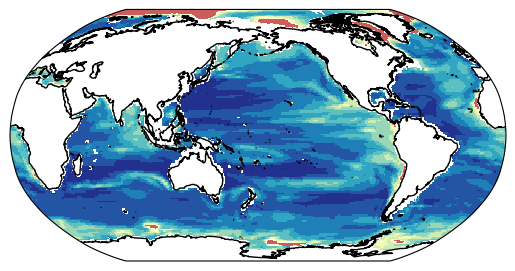

In [72]:
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
ax.pcolormesh(lon, lat, impr_min, 
                vmin=-.1, vmax=1, cmap=newcmp,
                transform=ccrs.PlateCarree(central_longitude=0, globe=None))
ax.coastlines('50m')

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_58421/2775976203.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


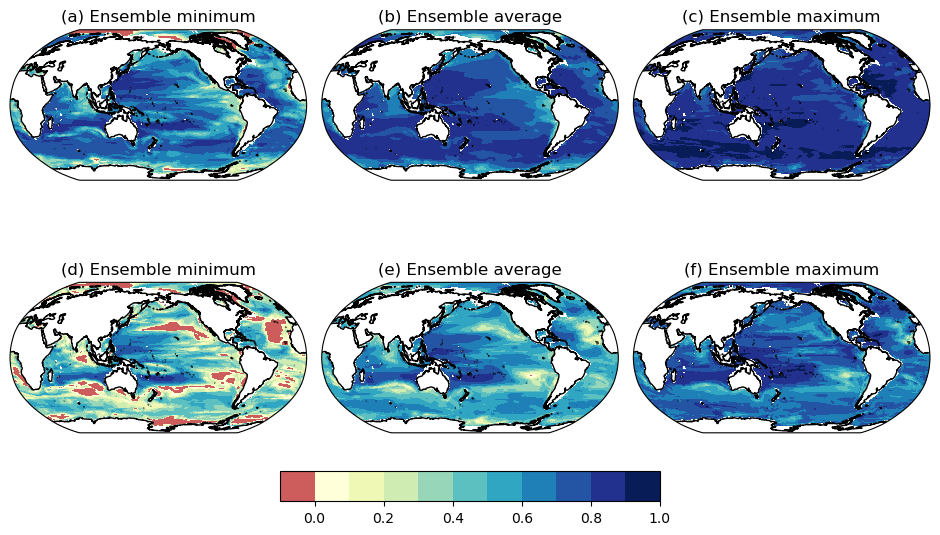

In [78]:
####
fig = plt.figure(figsize=(9.5, 6))
ax0 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(a) Ensemble minimum')
ax0.coastlines('50m')
im0 = ax0.pcolormesh(lon, lat, impr_min, vmin=-.1, vmax=1,
                   transform=ccrs.PlateCarree(central_longitude=0, globe=None),
                   cmap=newcmp)

ax1 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(b) Ensemble average')
ax1.coastlines('50m')
ax1.pcolormesh(lon, lat, impr_avg, vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp,rasterized=True)

ax2 = plt.subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(c) Ensemble maximum')
ax2.coastlines('50m')
ax2.pcolormesh(lon, lat, impr_max, vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp,rasterized=True)

ax3 = plt.subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(d) Ensemble minimum')
ax3.coastlines('50m')
ax3.pcolormesh(lon, lat, impr_mind, vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp,rasterized=True)

ax4 = plt.subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(e) Ensemble average')
ax4.coastlines('50m')
ax4.pcolormesh(lon, lat, impr_avgd, vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp,rasterized=True)

ax5 = plt.subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=180))
plt.title(r'(f) Ensemble maximum')
ax5.coastlines('50m')
im = ax5.pcolormesh(lon, lat, impr_maxd, vmin=-.1, vmax=1, 
             transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
             cmap=newcmp,rasterized=True)
ax_cbar1 = fig.add_axes([0.3, 0.05, .4, 0.05])
fig.colorbar(im, cax=ax_cbar1, orientation="horizontal", pad=0.2)
fig.tight_layout()
plt.savefig('pc_manuscript_figures/improv_dense_t100.png', format='png', dpi=150)

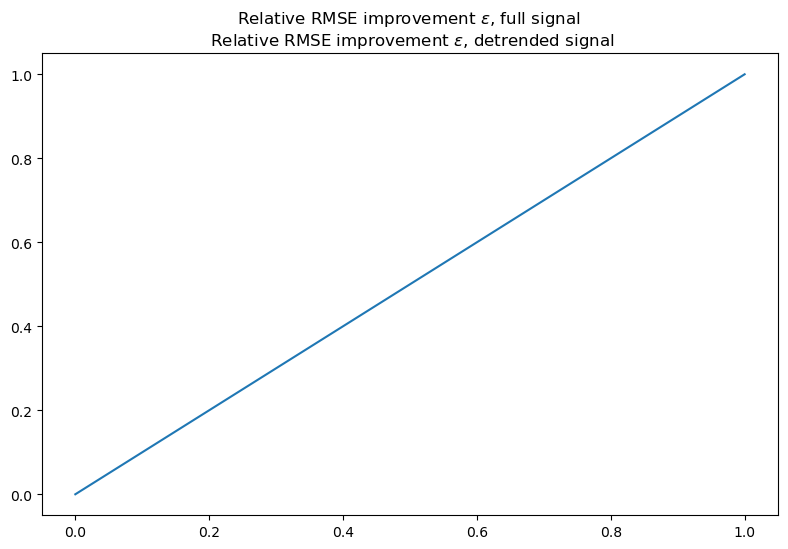

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [80]:
fig = plt.figure(figsize=(9.5, 6))
plt.plot(np.arange(2), np.arange(2))
plt.title('Relative RMSE improvement $\epsilon$, full signal \n Relative RMSE improvement $\epsilon$, detrended signal')
plt.savefig('pc_manuscript_figures/impr_titles.png', format='png', dpi=150)